In [55]:
# First code block is the import libraries  
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

pd.reset_option('^display.', silent=True)

In [56]:
def data_splitting(df: pd.DataFrame):
    df_new = df
        
    # handling the seat of passengers 
    df_new[['Cabin_deck','Cabin_num','Cabin_side']] = df['Cabin'].str.split('/',expand=True)

    # handling spending of each passengers : RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
    df_new[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]] = df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].fillna(0)
    df_new.loc[:, ['Total_spending']] = df_new['RoomService'] + df_new['FoodCourt'] + df_new['ShoppingMall'] + df_new['Spa'] + df_new['VRDeck']

    if 'Transported' in df_new.columns:
        df_processedData = df_new[
            [   'PassengerId', 'HomePlanet', 'CryoSleep',
                'Cabin_deck', 'Cabin_num', 'Cabin_side', 
                'Destination', 'Age',
                'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total_spending',
                'Name',
                'Transported'
            ]
        ]
    else:
        df_processedData = df_new[
            [   'PassengerId', 'HomePlanet', 'CryoSleep',
                'Cabin_deck', 'Cabin_num', 'Cabin_side', 
                'Destination', 'Age',
                'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total_spending',
                'Name'
            ]
        ]
    
    return df_processedData

In [80]:
def categorize_spending(df: pd.DataFrame):
    df_new = df

    mean_value = df_new['Total_spending'].mean()
    std_value = df_new['Total_spending'].std()

    thresholds = [
        float('-inf'), 
        mean_value - 0.5 * std_value,
        mean_value + 0.5 * std_value, 
        float('inf')
    ]

    df_new['spending_Categ'] = pd.cut(df['Total_spending'], bins=thresholds, labels=['Low', 'Medium', 'High'])

    return df_new

In [98]:
def categorize_Age(df: pd.DataFrame):
    df_new = df

    mean_value = df_new['Age'].mean()
    std_value = df_new['Age'].std()

    thresholds = [
        float('-inf'), 
        mean_value - 1.5 * std_value, 
        mean_value - 0.5 * std_value,
        mean_value + 0.5 * std_value, 
        mean_value + 1.5 * std_value, 
        float('inf')
    ]   

    df_new['Age_Categ'] = pd.cut(df['Age'], bins=thresholds, labels=['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh'])

    return df_new

In [99]:
def dropCols(df: pd.DataFrame):

    if 'Transported' in df.columns:
        df_new = df[
            [   'HomePlanet', 'CryoSleep',
                'Cabin_deck', 'Cabin_side', 
                'Age_Categ',
                'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                'spending_Categ',
                'Transported'
            ]
        ]
    else:
        df_new = df[
            [   'HomePlanet', 'CryoSleep',
                'Cabin_deck', 'Cabin_side',
                'Age_Categ',
                'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                'spending_Categ'
            ]
        ]
    return df_new

In [83]:
def fill_null(df: pd.DataFrame):
    # fill null record: HomePlanet, CryoSleep, Cabin_deck, Cabin_side, Age
    df_new = df
    # df_new['Age'] = df['Age'].fillna(int(df['Age'].mean()))

    # fill na value of CryoSleep
    mapping = {
        'High': False,
        'Medium': False,
        'Low': True
    }
    

    Medium_ratio = [32.64, 1.99, 9.74]  # Ratio of Earth, Europa, Mars in Medium spending
    Low_ratio = [20.54, 12.03, 9.57]  # Ratio of Earth, Europa, Mars in low spending
    homePlanet_labels = ['Earth', 'Europa', 'Mars']

    # Fill the missing values in 'sleep' column based on 'categ' labels
    # df_new['CryoSleep'] = df.apply(lambda row: mapping[row['spending_Categ']] if pd.isna(row['CryoSleep']) else row['CryoSleep'], axis=1)

    for index, row in df.iterrows():
        if pd.isna(row['CryoSleep']):
            df_new.at[index, 'CryoSleep'] = mapping[row['spending_Categ']]

        if pd.isna(row['HomePlanet']):
            spendCat = row['spending_Categ']

            if spendCat == 'High':
                df_new.at[index, 'HomePlanet'] = 'Europa'
            elif spendCat == 'Medium':
                df_new.at[index, 'HomePlanet'] = random.choices(homePlanet_labels, weights=Medium_ratio)[0]
            elif spendCat == 'Low':
                 df_new.at[index, 'HomePlanet'] = random.choices(homePlanet_labels, weights=Low_ratio)[0]

    return df_new

In [104]:
def oneHot(df: pd.DataFrame):
    # apply one-hot encoding to non-numberic data
    one_hot= pd.DataFrame()
    df['CryoSleep'] = df['CryoSleep'].astype(bool)
    one_hot = pd.get_dummies(df)

    # reorder the dataframe
    if 'Transported' in df.columns:
        one_hot = one_hot[['CryoSleep', 
            'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 
            'Cabin_deck_A', 'Cabin_deck_B', 'Cabin_deck_C', 
            'Cabin_deck_D', 'Cabin_deck_E', 'Cabin_deck_F',
            'Cabin_deck_G', 'Cabin_deck_T', 
            'Cabin_side_P', 'Cabin_side_S',
            'Age_Categ_VeryLow', 'Age_Categ_Low', 'Age_Categ_Medium', 'Age_Categ_High', 'Age_Categ_VeryHigh',
            'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
            'spending_Categ_Low', 'spending_Categ_Medium', 'spending_Categ_High',
            'Transported'
        ]]
    else:
        one_hot = one_hot[['CryoSleep', 
            'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 
            'Cabin_deck_A', 'Cabin_deck_B', 'Cabin_deck_C', 
            'Cabin_deck_D', 'Cabin_deck_E', 'Cabin_deck_F',
            'Cabin_deck_G', 'Cabin_deck_T', 
            'Cabin_side_P', 'Cabin_side_S',
            'Age_Categ_VeryLow', 'Age_Categ_Low', 'Age_Categ_Medium', 'Age_Categ_High', 'Age_Categ_VeryHigh',
            'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
            'spending_Categ_Low', 'spending_Categ_Medium', 'spending_Categ_High'
        ]]

    return one_hot

In [61]:
# normalize the data

def normalize(df):
    # age = df['Age']
    floatCols = df.iloc[:, 4:10]

    scaler = MinMaxScaler()
    # age = scaler.fit_transform(pd.DataFrame(age))
    temp = scaler.fit_transform(floatCols)

    normalized = df
    # normalized['Age'] = pd.DataFrame(age)
    normalized.iloc[:, 4:10] = temp

    return normalized

In [105]:
def dataProcess(df: pd.DataFrame):
    
    df_new = data_splitting(df)
    df_new = categorize_spending(df_new)
    df_new = categorize_Age(df_new)
    df_new = dropCols(df_new)
    df_new = fill_null(df_new)
    # df_new = normalize(df_new)
    df_new = oneHot(df_new)

    return df_new

In [106]:
rawTrain_dataPath = '../spaceship-titanic_rawData/spaceship_train.csv'
rawTest_dataPath = '../spaceship-titanic_rawData/spaceship_test.csv'


df_public = pd.read_csv(rawTrain_dataPath)
df_private = pd.read_csv(rawTest_dataPath)

# we did not compute the normalization
pre_train = dataProcess(df_public)
pre_test = dataProcess(df_private)



In [108]:
pre_train.columns

Index(['CryoSleep', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Cabin_deck_A', 'Cabin_deck_B', 'Cabin_deck_C', 'Cabin_deck_D',
       'Cabin_deck_E', 'Cabin_deck_F', 'Cabin_deck_G', 'Cabin_deck_T',
       'Cabin_side_P', 'Cabin_side_S', 'Age_Categ_VeryLow', 'Age_Categ_Low',
       'Age_Categ_Medium', 'Age_Categ_High', 'Age_Categ_VeryHigh',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'spending_Categ_Low', 'spending_Categ_Medium', 'spending_Categ_High',
       'Transported'],
      dtype='object')

In [109]:
# Export result
filename = str(os.path.basename(globals()['__vsc_ipynb_file__'])).replace('.ipynb', '')

train_export = '../preprocess_train_dataset/' + filename + '_train.csv'
test_export = '../preprocess_test_dataset/' + filename + '_test.csv'

pre_train.to_csv(train_export, sep=',', encoding='utf-8', index=False)
pre_test.to_csv(test_export, sep=',', encoding='utf-8', index=False)

In [111]:
pre_test.isna().sum()

CryoSleep                0
HomePlanet_Earth         0
HomePlanet_Europa        0
HomePlanet_Mars          0
Cabin_deck_A             0
Cabin_deck_B             0
Cabin_deck_C             0
Cabin_deck_D             0
Cabin_deck_E             0
Cabin_deck_F             0
Cabin_deck_G             0
Cabin_deck_T             0
Cabin_side_P             0
Cabin_side_S             0
Age_Categ_VeryLow        0
Age_Categ_Low            0
Age_Categ_Medium         0
Age_Categ_High           0
Age_Categ_VeryHigh       0
RoomService              0
FoodCourt                0
ShoppingMall             0
Spa                      0
VRDeck                   0
spending_Categ_Low       0
spending_Categ_Medium    0
spending_Categ_High      0
dtype: int64

<Axes: ylabel='Density'>

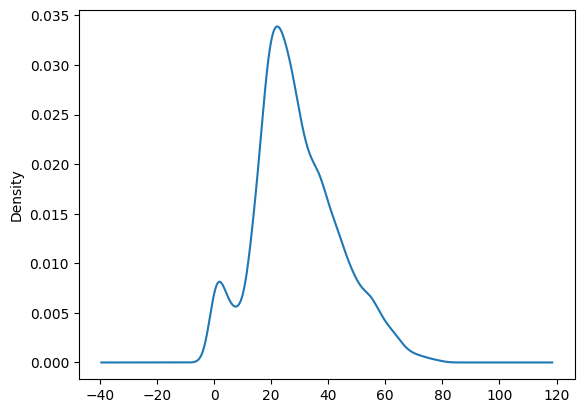

In [73]:
pd.set_option('display.float_format', '{:.2%}'.format)
df_public['Age'].plot(kind='kde')

<Axes: ylabel='Frequency'>

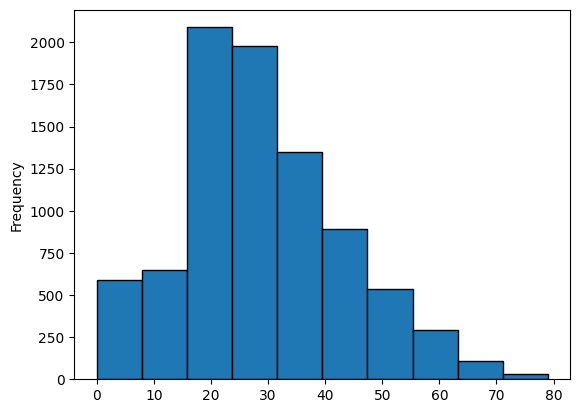

In [74]:
df_public['Age'].plot(kind='hist', edgecolor='black')

In [75]:
mean_value = df_public['Age'].mean()
std_value = df_public['Age'].std()

print("Age:")
print("\tMean:\t", mean_value)
print("\tsd:\t", std_value)

Age:
	Mean:	 28.82793046746535
	sd:	 14.48902142390878


In [76]:
thresholds = [
    float('-inf'), 
    mean_value - 1.5 * std_value, 
    mean_value - 0.5 * std_value,
    mean_value + 0.5 * std_value, 
    mean_value + 1.5 * std_value, 
    float('inf')
]


df_public['Age_5catg'] = pd.cut(df_public['Age'], bins=thresholds, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
df_public.value_counts(['Age_5catg', 'Transported'], normalize=True).sort_index(ascending=False).to_frame()

proportion
Age_5catg Transported            
Very High True              4.19%
          False             4.46%
High      True              9.10%
          False             9.67%
Medium    True             19.18%
          False            21.14%
Low       True             12.80%
          False            12.51%
Very Low  True              5.09%
          False             1.86%

In [79]:
thresholds = [
    float('-inf'), 
    mean_value - 1 * std_value, 
    mean_value - 0.5 * std_value,
    mean_value + 0.5 * std_value, 
    mean_value + 1 * std_value, 
    float('inf')
]


df_public['Age_5catg'] = pd.cut(df_public['Age'], bins=thresholds, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
df_public.value_counts(['Age_5catg', 'Transported'], normalize=True).sort_index(ascending=False).to_frame()

proportion
Age_5catg Transported            
Very High True              7.83%
          False             8.08%
High      True              5.46%
          False             6.05%
Medium    True             19.18%
          False            21.14%
Low       True              9.51%
          False            10.00%
Very Low  True              8.37%
          False             4.37%

In [77]:
thresholds = [
    float('-inf'), 
    mean_value - 0.5 * std_value,
    mean_value + 0.5 * std_value, 
    float('inf')
]


df_public['Age_3catg'] = pd.cut(df_public['Age'], bins=thresholds, labels=['Low', 'Medium', 'High'])
df_public.value_counts(['Age_3catg', 'Transported'], normalize=True).sort_index(ascending=False).to_frame()

proportion
Age_3catg Transported            
High      True             13.30%
          False            14.13%
Medium    True             19.18%
          False            21.14%
Low       True             17.89%
          False            14.36%